# Model Performance


## Import required packages

In [55]:
%matplotlib inline
from dmba import regressionSummary, classificationSummary, liftChart, gainsChart
from dmba import adjusted_r2_score, AIC_score, BIC_score
import math
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import metrics
import matplotlib.pylab as plt

## Regression Modeling

We will investigate both explanatory and predictive models to determine the probability of admission to graduate school based on a variety of predictors.

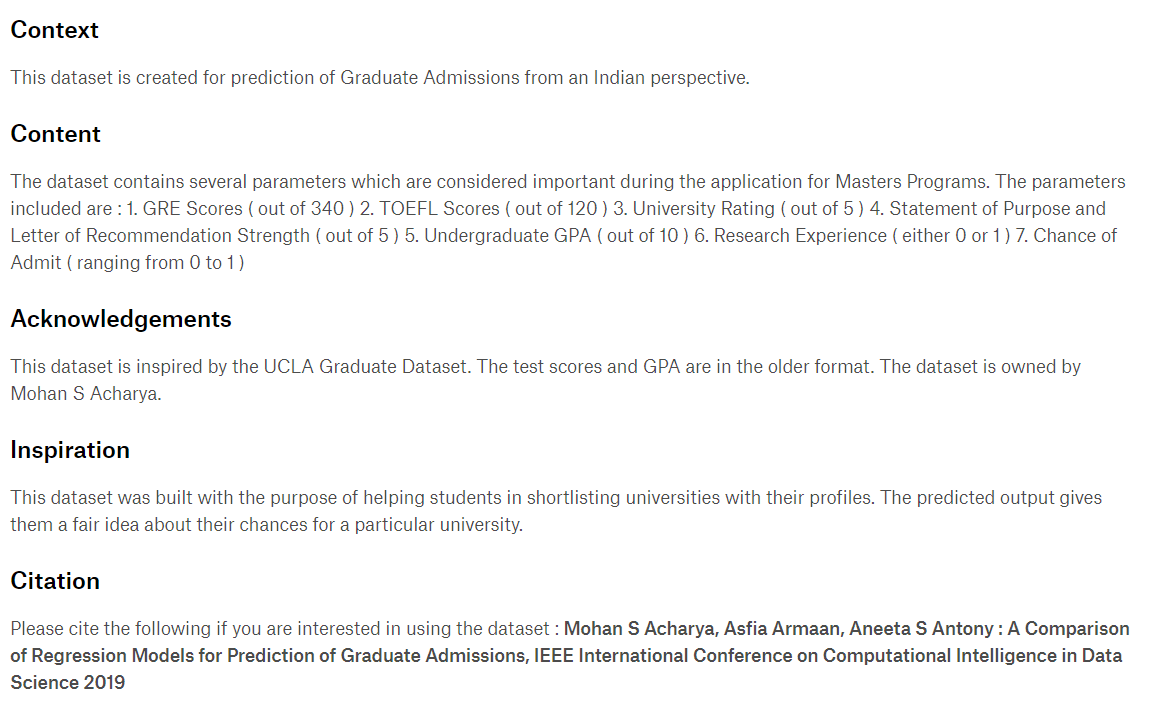

In [3]:
# Reduce data frame to the top 1000 rows and select columns for regression analysis
data_df = pd.read_csv('Admission_Predict.csv')

In [4]:
data_df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [18]:
data_df.shape

(400, 8)

In [5]:
# Let's remove the non-essential variable, Serial No., as it adds noise without adding useful information.

data_df = data_df.drop(columns=['Serial No.'])

In [6]:
#  Now we'll replace spaces with underscores (Python doesn't like variable names with spaces in them)

data_df.columns = [s.strip().replace(' ', '_') for s in data_df.columns] # change spaces into underscores in variable names

data_df.columns

Index(['GRE_Score', 'TOEFL_Score', 'University_Rating', 'SOP', 'LOR', 'CGPA',
       'Research', 'Chance_of_Admit'],
      dtype='object')

In [7]:
# At this point, let's separate the predictors from the target variable 'Chance_of_Admit'

X = data_df.drop('Chance_of_Admit', axis=1)

y = data_df['Chance_of_Admit']

In [15]:
# Taking all of the samples allows us to build an explanatory model

algo = LinearRegression()

explanatory_model = algo.fit(X, y)

In [16]:
# Print out the measures of model fit

pred_y = model.predict(X)

print('adjusted r2 : ', adjusted_r2_score(y, pred_y, explanatory_model))
print('AIC : ', AIC_score(y, pred_y, explanatory_model))
print('BIC : ', BIC_score(y, pred_y, explanatory_model))

adjusted r2 :  0.7999619321964118
AIC :  -1056.7463682972084
BIC :  -1020.8231873732366


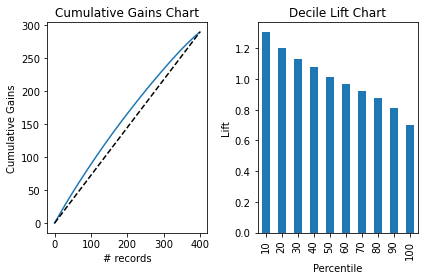

In [17]:
# Gain and lift charts for inspecting model goodness of fit

pred_v = pd.Series(model.predict(X))

pred_v = pred_v.sort_values(ascending=False)

fig,axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(pred_v, ax=axes[0])
ax.set_ylabel('Cumulative Gains')
ax.set_title("Cumulative Gains Chart")

ax = liftChart(pred_v, ax=axes[1], labelBars=False)
ax.set_ylabel("Lift")

plt.tight_layout()
plt.show()

### Using the same data partitioned, we'll build a predictive model

In [19]:
# partition the data into training and test sets with 50% of the data in each

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.5, random_state=1)

In [20]:
# Using just the training data for fitting allows us to build predictive model

algo = LinearRegression()

predictive_model = algo.fit(train_X, train_y)

1.0


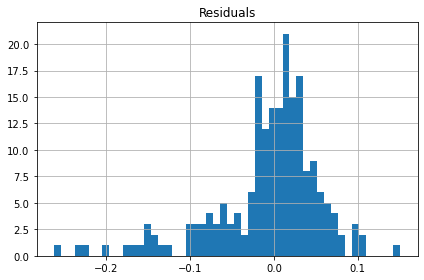

In [23]:
# Display a histogram of the residuals to determine whether to use RMSE or MAE

%matplotlib inline

data_lm_pred = model.predict(test_X)
all_residuals = test_y - data_lm_pred

# Determine the percentage of datapoints with a residual in [-200000, 200000] = approx. 75\%
print(len(all_residuals[(all_residuals > -200000) & (all_residuals < 200000)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=50)

plt.tight_layout()
plt.show()

In [24]:
# print performance measures of the training and the test data

regressionSummary(train_y, model.predict(train_X)) # data used to fit the model
print()
regressionSummary(test_y, model.predict(test_X)) # data from the future that the model never saw


Regression statistics

                      Mean Error (ME) : 0.0067
       Root Mean Squared Error (RMSE) : 0.0625
            Mean Absolute Error (MAE) : 0.0460
          Mean Percentage Error (MPE) : 0.1896
Mean Absolute Percentage Error (MAPE) : 7.0938


Regression statistics

                      Mean Error (ME) : -0.0067
       Root Mean Squared Error (RMSE) : 0.0637
            Mean Absolute Error (MAE) : 0.0442
          Mean Percentage Error (MPE) : -2.4699
Mean Absolute Percentage Error (MAPE) : 7.4896


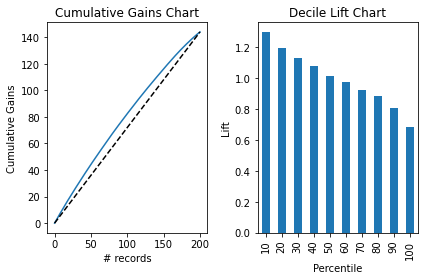

In [22]:
# Gain and lift charts for inspecting model predictive performance by using the test data

pred_v = pd.Series(model.predict(test_X))

pred_v = pred_v.sort_values(ascending=False)

fig,axes = plt.subplots(nrows=1, ncols=2)
ax = gainsChart(pred_v, ax=axes[0])
ax.set_ylabel('Cumulative Gains')
ax.set_title("Cumulative Gains Chart")

ax = liftChart(pred_v, ax=axes[1], labelBars=False)
ax.set_ylabel("Lift")

plt.tight_layout()
plt.show()

## Classification Modeling

### The Mushroom dataset is designed to predict whether a mushroom is edible or poisonous.

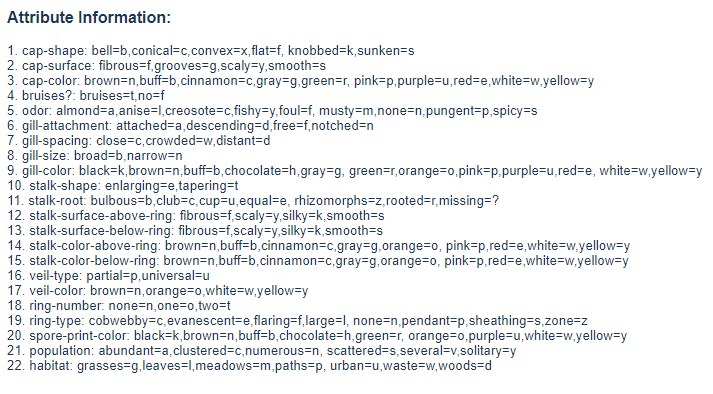

In [30]:
data_df = pd.read_csv('mushroom.csv')

In [31]:
data_df.head()

,Class,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [32]:
data_df.shape

(8124, 23)

In [33]:
# Let's separate the predictors from the target variable

X = data_df.drop('Class', axis=1)

y = data_df['Class']

In [34]:
# Because of predictors that are text, we must encode into numbers

X = pd.get_dummies(X, prefix_sep='_', drop_first=True)

In [44]:
# Now we have to convert the target variable from letters (p and e) into numbers

y = y.astype('category').cat.codes

In [45]:
# Let's see how many predictors we have after one-hot encoding

print(len(X.columns))

95


In [46]:
# We'll start by constructing an explanatory model using all of the data

algo = LogisticRegression(penalty="l2", C=1E42, solver='liblinear', class_weight = None, 
                          max_iter=5000, random_state=1)

model = algo.fit(X, y)

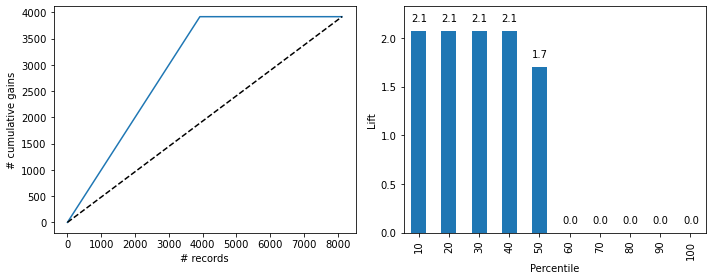

In [47]:
%matplotlib inline

logit_reg_pred = model.predict(X)
logit_reg_proba = model.predict_proba(X)
logit_result = pd.DataFrame({'actual': y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

In [48]:
# Let's check the classification accuracy on the explanatory model

classificationSummary(y, model.predict(X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 4208    0
     1    0 3916


### Using the same data partitioned, we'll build a predictive model

In [49]:
# partition the data into training and test sets with 50% of the data in each

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.5, stratify=y, random_state=1)

In [50]:
# We'll start by constructing predictive model using only the training data

algo = LogisticRegression(penalty="l2", C=1E42, solver='liblinear', class_weight = None, 
                          max_iter=5000, random_state=1)

model = algo.fit(train_X, train_y)

In [51]:
# Let's check the classification accuracy on the explanatory model

classificationSummary(train_y, model.predict(train_X))
print()
classificationSummary(test_y, model.predict(test_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2104    0
     1    0 1958

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual    0    1
     0 2104    0
     1    0 1958


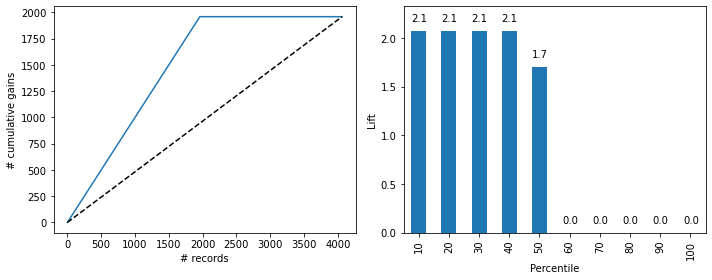

In [52]:
%matplotlib inline

logit_reg_pred = model.predict(test_X)
logit_reg_proba = model.predict_proba(test_X)
logit_result = pd.DataFrame({'actual': test_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

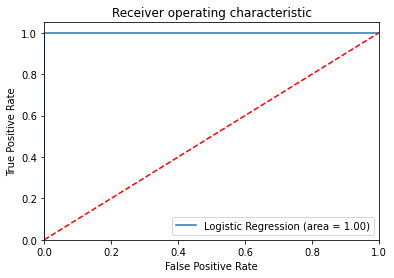

In [56]:
logit_reg_pred = model.predict(test_X)
logit_reg_proba = model.predict_proba(test_X)

preds = logit_reg_proba[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_y, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()